In [54]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS

# Load the training data

In [55]:
# Define file paths and data schemas

trainingText = sc.textFile('s3n://uwong.expedia.hotel/training_data/train.csv.gz')

# Parse text into RDDs

trainingData = (trainingText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = trainingData.first()

dfTrainingData = (trainingData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfTrainingData.show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

# Take a small sample of the data (from 37 million down to 3,700,000)

In [56]:
# Take a smaller sample for faster debugging
dfTrainingSample = dfTrainingData.sample(withReplacement=False, fraction=0.1, seed=42)
dfTrainingSample.cache()
dfTrainingSample.registerTempTable('training_data')

# Transform data to count bookings and clicks by user_id and hotel_cluster

In [57]:
# For each booking row

dfBookings = (dfTrainingSample
                    .filter(dfTrainingSample.is_booking == 1)
                    .groupBy(['user_id', 'hotel_cluster'])
                    .agg(F.count('is_booking').alias('num_bookings'))
              )
dfBookings.show()

# Join the number of preceding clicks 

+-------+-------------+------------+
|user_id|hotel_cluster|num_bookings|
+-------+-------------+------------+
|   9681|           10|           1|
|  86489|           40|           1|
|  96156|           28|           1|
| 118700|           71|           1|
| 166530|           19|           1|
| 198591|           51|           1|
| 295421|           51|           1|
| 331829|           29|           1|
| 418035|           79|           2|
| 734166|           19|           1|
| 775364|           78|           1|
| 813426|           65|           1|
|1073964|           50|           1|
|1094225|            2|           1|
|1121162|           70|           1|
|  27869|            3|           1|
|  46673|           98|           1|
| 119794|           91|           1|
| 322343|           68|           1|
| 322556|           75|           1|
+-------+-------------+------------+
only showing top 20 rows



In [58]:
dfBookings.select('num_bookings').describe().show()

+-------+-------------------+
|summary|       num_bookings|
+-------+-------------------+
|  count|             288980|
|   mean|  1.038930029759845|
| stddev|0.23029356098505782|
|    min|                  1|
|    max|                 11|
+-------+-------------------+



In [59]:
dfClicks = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.count('is_booking').alias('num_clicks'))
            )
dfClicks.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_clicks|
+-------+-------------+----------+
|   7158|           48|         1|
|   9681|           10|         1|
|   9701|           82|         1|
|  10106|           76|         1|
|  23532|           77|         1|
|  37943|           25|         1|
|  70594|           95|         1|
|  70929|           37|         1|
|  79449|           62|         1|
|  82825|           68|         1|
|  86873|           23|         1|
|  88024|           96|         1|
|  90864|           37|         1|
|  94390|           40|         1|
|  98785|           64|         1|
| 117381|           37|         1|
| 118700|           71|         1|
| 121243|           33|         1|
| 140518|           68|         1|
| 143360|           26|         1|
+-------+-------------+----------+
only showing top 20 rows



In [60]:
dfClicks.select('num_clicks').describe().show()

+-------+------------------+
|summary|        num_clicks|
+-------+------------------+
|  count|           2877896|
|   mean|1.2043590178380317|
| stddev|0.6126761978177979|
|    min|                 1|
|    max|                33|
+-------+------------------+



In [61]:
dfEvents = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.sum('cnt').cast('int').alias('num_events'))
            )
dfEvents.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_events|
+-------+-------------+----------+
|   7158|           48|         2|
|   9681|           10|         1|
|   9701|           82|         1|
|  10106|           76|         3|
|  23532|           77|         1|
|  37943|           25|         1|
|  70594|           95|         1|
|  70929|           37|         1|
|  79449|           62|         2|
|  82825|           68|         2|
|  86873|           23|         2|
|  88024|           96|         1|
|  90864|           37|         1|
|  94390|           40|         1|
|  98785|           64|         3|
| 117381|           37|         1|
| 118700|           71|         1|
| 121243|           33|         1|
| 140518|           68|         1|
| 143360|           26|         1|
+-------+-------------+----------+
only showing top 20 rows



In [62]:
dfEvents.select('num_events').describe().show()

+-------+------------------+
|summary|        num_events|
+-------+------------------+
|  count|           2877896|
|   mean|1.8349888251694988|
| stddev|1.7352191056406086|
|    min|                 1|
|    max|                85|
+-------+------------------+



In [63]:
dfBookingClicks = (dfBookings
                  .join(dfClicks, 
#                         on=(dfBookings.user_id == dfClicks.user_id) & (dfBookings.hotel_cluster == dfClicks.hotel_cluster), 
                        on=['user_id', 'hotel_cluster'],
                        how='outer')
                   .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks')
                  )

dfBookingClicksEvents = (dfBookingClicks
                         .join(dfEvents, 
                            on=['user_id', 'hotel_cluster'],
                            how='outer')
                         .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks', 'num_events')
                         .na.fill(0)
                        )
dfBookingClicksEvents.show()

+-------+-------------+------------+----------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|
+-------+-------------+------------+----------+----------+
| 100018|           98|           0|         1|         1|
|1000184|           89|           1|         1|         2|
|1000322|           36|           0|         1|         1|
|1000364|           16|           0|         1|         1|
|1000367|           42|           0|         1|         4|
| 100043|           10|           0|         1|         1|
|1000652|            5|           0|         1|         1|
|1000652|           61|           0|         1|         1|
|1000656|           18|           0|         1|         1|
|1000706|           70|           1|         1|         1|
|1000751|           25|           0|         2|         3|
|1000814|            5|           0|         1|         1|
|1000900|           41|           0|         2|         2|
|1000922|           52|           0|         1|         

# Create rating columns that combines bookings and clicks into a single value

In [64]:
bookingWeight = 5
dfBookingClicksEventsRating = (dfBookingClicksEvents
                               .withColumn('rating', 
                                           bookingWeight * dfBookingClicksEvents.num_bookings +  dfBookingClicksEvents.num_events)
                               )
dfBookingClicksEventsRating.show()

+-------+-------------+------------+----------+----------+------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|
+-------+-------------+------------+----------+----------+------+
| 100018|           98|           0|         1|         1|     1|
|1000184|           89|           1|         1|         2|     7|
|1000322|           36|           0|         1|         1|     1|
|1000364|           16|           0|         1|         1|     1|
|1000367|           42|           0|         1|         4|     4|
| 100043|           10|           0|         1|         1|     1|
|1000652|            5|           0|         1|         1|     1|
|1000652|           61|           0|         1|         1|     1|
|1000656|           18|           0|         1|         1|     1|
|1000706|           70|           1|         1|         1|     6|
|1000751|           25|           0|         2|         3|     3|
|1000814|            5|           0|         1|         1|     1|
|1000900| 

In [65]:
dfBookingClicksEventsRating.select('num_bookings', 'num_clicks', 'num_events', 'rating').describe().show()

+-------+-------------------+------------------+------------------+------------------+
|summary|       num_bookings|        num_clicks|        num_events|            rating|
+-------+-------------------+------------------+------------------+------------------+
|  count|            3073940|           3073940|           3073940|           3073940|
|   mean|0.09766944052258665|1.1275496593947831| 1.717960337547252|2.2063075401601853|
| stddev| 0.3113169164589022|0.6618449425744324|1.7378166335841225| 2.140839761749712|
|    min|                  0|                 0|                 0|                 1|
|    max|                 11|                33|                85|                85|
+-------+-------------------+------------------+------------------+------------------+



# Fit the recommender model



### Insert a cross validation step to tune the hyper parameters of the recommender

In [66]:
als = ALS(rank=10, maxIter=5, implicitPrefs=True,
                          userCol="user_id", itemCol="hotel_cluster", ratingCol="rating")
recommendationModel = als.fit(dfBookingClicksEventsRating)

# Examine predictions made onto the same training data

In [67]:
# predict the 'ratings' (num_clicks) a user will make for each 
dfPredictions = recommendationModel.transform(dfBookingClicksEventsRating)

In [68]:
dfPredictionsSorted = (dfPredictions
                       .orderBy('prediction', ascending=False))
dfPredictionsSorted.show()

+-------+-------------+------------+----------+----------+------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|prediction|
+-------+-------------+------------+----------+----------+------+----------+
| 654247|           91|           0|         1|         1|     1| 1.5345811|
| 720948|           91|           0|         1|         1|     1| 1.4416041|
|1018318|           91|           0|         1|         1|     1| 1.4375095|
| 444244|           91|           0|         1|         1|     1| 1.4238319|
| 830287|           91|           0|         1|         1|     1| 1.4185873|
| 386632|           91|           0|         1|         1|     1| 1.4168973|
| 312491|           91|           0|         2|        10|    10| 1.4162362|
| 132306|           64|           0|         1|         1|     1| 1.4074084|
|  91832|           91|           0|         1|         1|     1| 1.4070861|
| 515747|           65|           0|         2|         2|     2| 1.4060632|

In [69]:
dfPredictionsSorted.select('prediction').describe().show()

+-------+-------------------+
|summary|         prediction|
+-------+-------------------+
|  count|            3073940|
|   mean| 0.4056543044985646|
| stddev|0.20787685291654615|
|    min|         -0.3166367|
|    max|          1.5345811|
+-------+-------------------+



# Evaluate the predictions

See if there is a correlation between the prediction we made and bookings, clicks, and combined rating

In [70]:
# Using pandas!

pdPredictions = dfPredictionsSorted.toPandas()

In [71]:
pdPredictions.head()

,user_id,hotel_cluster,num_bookings,num_clicks,num_events,rating,prediction
0,654247,91,0,1,1,1,1.534581
1,720948,91,0,1,1,1,1.441604
2,1018318,91,0,1,1,1,1.437510
3,444244,91,0,1,1,1,1.423832
4,830287,91,0,1,1,1,1.418587


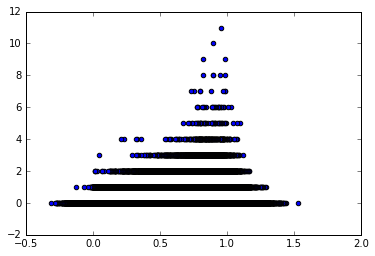

In [72]:
plt.scatter(pdPredictions.prediction, pdPredictions.num_bookings)

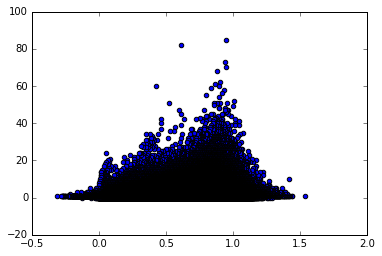

In [73]:
plt.scatter(pdPredictions.prediction, pdPredictions.num_events)

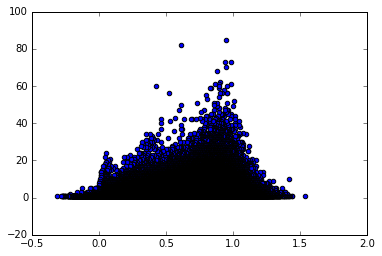

In [74]:
plt.scatter(pdPredictions.prediction, pdPredictions.rating)

# Prediction score vs. Number of click events for each hotel cluster

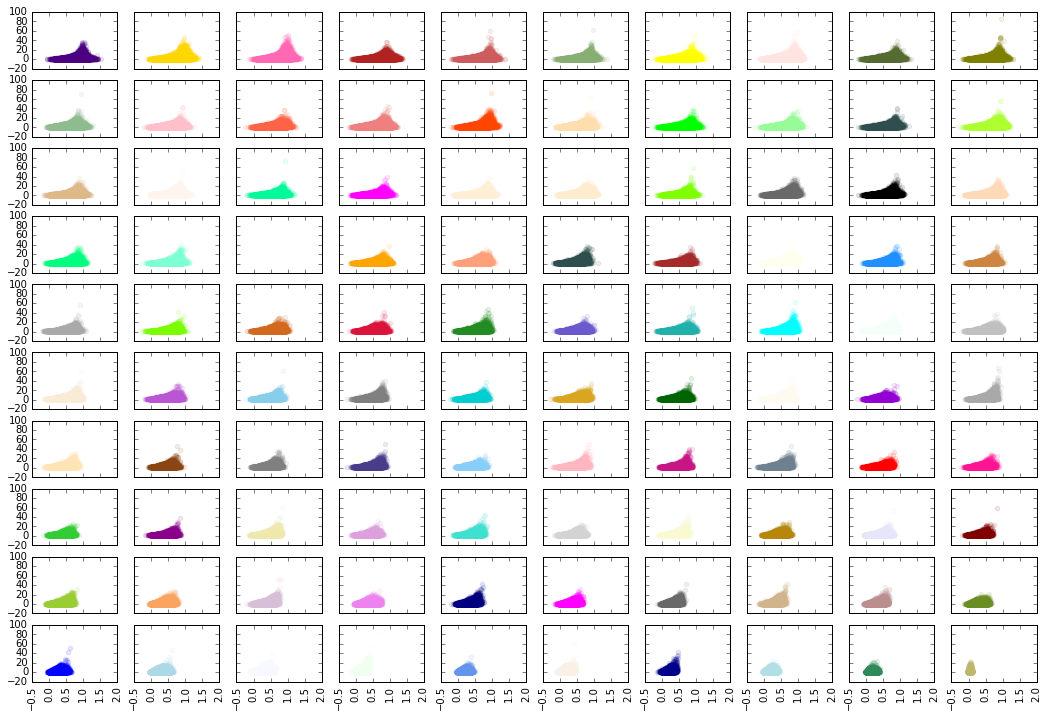

In [75]:
from matplotlib import colors
hotelList = pdPredictions.hotel_cluster.unique().tolist()
colorMap = colors.cnames.keys()
numRows = 10
numCols = 10
fig, ax = plt.subplots(nrows=numRows, ncols=numCols, figsize=(18,12), sharex=True, sharey=True)
for i, hotel in enumerate(hotelList):
    ix = i / numRows
    iy = i % numCols
#     print('%i, %i' % (ix, iy))
    plotData = pdPredictions.loc[pdPredictions.hotel_cluster == hotel]
    ax[ix][iy].scatter(plotData.prediction, plotData.rating, alpha=0.1, color = colorMap[i % len(colorMap)])
    
# plt.set_xlabel('Prediction')
# plt.set_ylabel('Number of click events + 5xnum_bookings')
    
for i in range(numRows):
    for j in range(numCols):

#         ax[i].set_xlabel('Time of commute start')
#         ax[i].set_ylabel('Duration in traffic (minutes)')

#         ax[i].set_ylim([40, 110])

#         ax[i].xaxis.set_visible(True)
#         ax[i].yaxis.set_visible(True)

        for tick in ax[i][j].get_xticklabels():
            tick.set_rotation(90)

## Prediction score vs. Number of Bookings for each hotel cluster

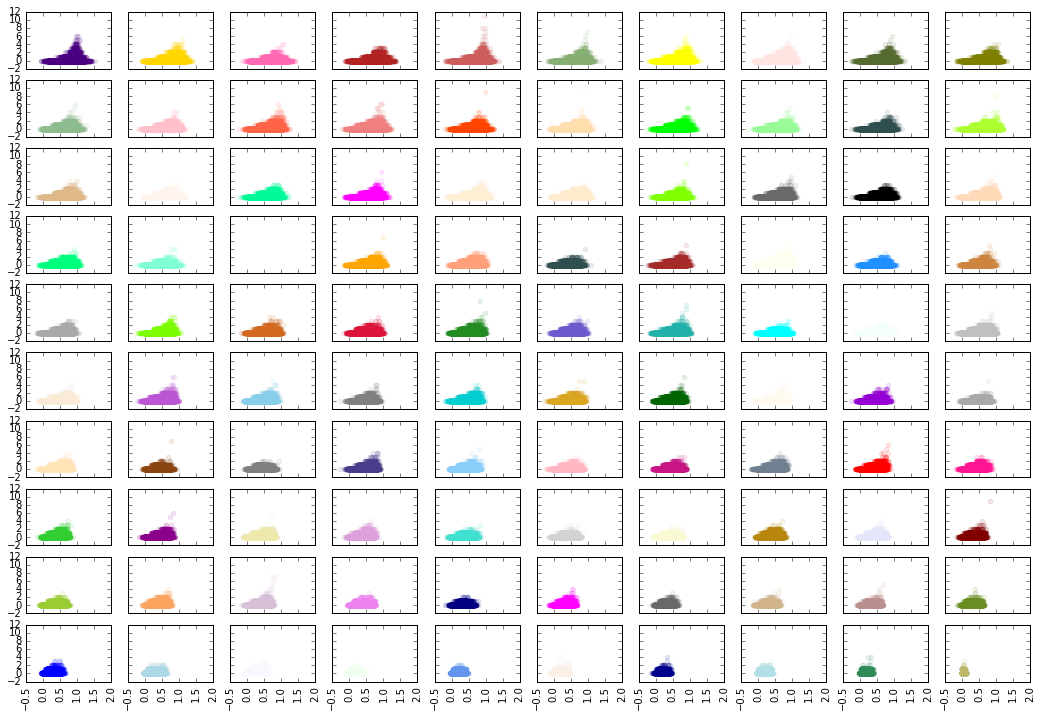

In [76]:
from matplotlib import colors
hotelList = pdPredictions.hotel_cluster.unique().tolist()
colorMap = colors.cnames.keys()
numRows = 10
numCols = 10
fig, ax = plt.subplots(nrows=numRows, ncols=numCols, figsize=(18,12), sharex=True, sharey=True)
for i, hotel in enumerate(hotelList):
    ix = i / numRows
    iy = i % numCols
#     print('%i, %i' % (ix, iy))
    plotData = pdPredictions.loc[pdPredictions.hotel_cluster == hotel]
    ax[ix][iy].scatter(plotData.prediction, plotData.num_bookings, alpha=0.1, color = colorMap[i % len(colorMap)])
    
# plt.set_xlabel('Prediction')
# plt.set_ylabel('Number of click events + 5xnum_bookings')
    
for i in range(numRows):
    for j in range(numCols):

#         ax[i].set_xlabel('Time of commute start')
#         ax[i].set_ylabel('Duration in traffic (minutes)')

#         ax[i].set_ylim([40, 110])

#         ax[i].xaxis.set_visible(True)
#         ax[i].yaxis.set_visible(True)

        for tick in ax[i][j].get_xticklabels():
            tick.set_rotation(90)

### Calculate Mean Average Precision @ 5

The evaluation criteria is described here:
* https://www.kaggle.com/c/expedia-hotel-recommendations/details/evaluation
* https://www.kaggle.com/wiki/MeanAveragePrecision

$MAP@5 = \frac{1}{|U|}\sum_{u=1}^{|U|}\sum_{k=1}^{min(5,n)}P(k)$
where 
* |U| is the number of user events
* P(k) precision at cutoff k in the item list
* n is the number of predicted hotel clusters per user

Submission csv file format:

id,hotel_cluster

0,99 3 1 75 20

1,2 50 30 23 9

# Output results to S3

In [77]:
pdPredictions.shape

(3073940, 7)

In [81]:
outputPath = 's3n://uwong.expedia.hotel/output/'
outputFile = 'recommendations.csv'

# Export spark dataframe?
dfPredictionsSorted.save(outputPath+outputFile)

/usr/lib/spark/python/pyspark/sql/dataframe.py:167: UserWarning: insertInto is deprecated. Use write.save() instead.
  warnings.warn("insertInto is deprecated. Use write.save() instead.")
